In [1]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io
import pytz

plt.style.use('ggplot')

In [2]:
with pd.HDFStore('./large_files/data2.h5', mode='r') as store:
    df_ = store.get('data/data_imputed_20240226')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522881 entries, 525 to 138563
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 211.7+ MB


In [3]:
df = df_.set_index('datetime', drop=False)
df = df.loc[df.index.year.isin([2021, 2022, 2023])]
df = df.loc[df.index.day_of_week == 2]

In [4]:
class CommInfoFractional(bt.CommissionInfo):
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)

class Strategy(bt.Strategy):
    params = (
        ('csv_writer', None),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.status_code = {
            6: 'Margin',
            7: 'Rejected',
            4: 'Canceled'
        }
        self.close_position = False

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
        cash = self.broker.get_cash()
        value = self.broker.get_value()
        shares = self.position.size
        print('%s, %s, Cash: %.2f, Portfolio Value: %.2f, Shares Owned: %d' % (dt.isoformat(), txt, cash, value, shares))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        order_action = 'Buy' if order.isbuy() else 'Sell'

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('Buy executed at %.2f' % order.executed.price)
                if self.params.buffer is not None:
                    action = 'Close' if self.close_position else 'Long'
                    self.params.buffer.write('%s,%s,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), action, order.executed.price))
                    self.close_position = False
            elif order.issell():
                self.log('Sell executed at %.2f' % order.executed.price)
                if self.params.buffer is not None:
                    action = 'Close' if self.close_position else 'Short'
                    self.params.buffer.write('%s,%s,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), action, order.executed.price))
                    self.close_position = False

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'{order_action} Order Not Executed: {self.status_code[order.status]}  Order Size: {order.size}')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' % (trade.pnl, trade.pnlcomm))

    def stop(self):
        if self.position:
            self.log('Closing position')
            self.close()
            self.close_position = True
            if self.params.buffer is not None:
                self.params.buffer.write('%s,Close,%.2f\n' % (self.datas[0].datetime.datetime(0).isoformat(), self.dataclose[0]))

    def next(self):
        pass

In [5]:
class Backtest:
    def __init__(self, df, capital=(100 * 1e3), margin=0.5):
        self.df = df
        self.buffer = io.StringIO()
        self.capital = capital
        self.margin = margin

    def fit(self, strategy, set_comm=False, **kwargs):
        self.buffer.write('Date,Action,Price\n')
        capital = self.capital
        df_result = []
        for day, df_day in self.df.groupby(pd.Grouper(key='datetime', freq='D')):
            if capital < (self.capital * 0.5):
                print('Early stopping')
                break

            if df_day.shape[0] == 0:
                continue
            
            df_day = df_day.copy()
            df_day = df_day[(df_day.index.hour >= 9) & (df_day.index.hour < 12)]
            df_day.index = df_day.index.tz_localize(None)
            data = bt.feeds.PandasData(dataname=df_day)
            
            cerebro = bt.Cerebro()
            cerebro.broker.setcash(capital)
            # if set_comm:
                # cerebro.broker.setcommission(commission=0.001)
            cerebro.addsizer(bt.sizers.PercentSizer, percents=100)
            cerebro.broker.addcommissioninfo(CommInfoFractional())
            cerebro.adddata(data)
            cerebro.addstrategy(strategy, buffer=self.buffer, total_len=df_day.shape[0], **kwargs)

            print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
            bt_results = cerebro.run()
            print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            print('\n\n')

            pnl = cerebro.broker.getvalue() - cerebro.broker.startingcash

            df_result.append({
                'datetime': day,
                'portfolio': cerebro.broker.getvalue(),
                'pnl': pnl,
            })
            capital = cerebro.broker.getvalue()
        self.df_result = pd.DataFrame(df_result)
        self.buffer.seek(0)  # Reset buffer position
        self.df_trades = pd.read_csv(self.buffer)

        return self.df_result, self.df_trades
    
    def evaluate(self):
        # supports long only strat
        self.df_trades['Date'] = pd.to_datetime(self.df_trades['Date'])
        sharpes = []
        for day, df_day in self.df_trades.groupby(pd.Grouper(key='Date', freq='D')):
            if df_day.shape[0] == 0:
                continue
            df_day = df_day.copy()
            df_buy = df_day[df_day['Action'] == 'Long']
            df_sell = df_day[df_day['Action'] == 'Short']
            df_close = df_day[df_day['Action'] == 'Close']

            returns = []
            if df_buy.shape[0] > 0:
                for idx, buy in df_buy.iterrows():
                    buy_time = buy['Date']
                    sell = df_close[df_close['Date'] > buy_time].iloc[0]['Price']
                    _return = (sell - buy['Price']) / buy['Price']
                    if isinstance(_return, float):
                        returns.append(_return)
                    else:
                        returns += _return.tolist()

            if df_sell.shape[0] > 0:
                for idx, sell in df_sell.iterrows():
                    sell_time = sell['Date']
                    buy = df_close[df_close['Date'] > sell_time].iloc[0]['Price']
                    _return = (buy - sell['Price']) / sell['Price']
                    if isinstance(_return, float):
                        returns.append(_return)
                    else:
                        returns += _return.tolist()

            returns = np.array(returns)
            n_winning_trades = (returns > 0).astype(int).sum()
            n_losing_trades = len(returns) - n_winning_trades
            
            sharpe_ratio = np.mean(returns) / max(0.001, np.std(returns))
            sharpes.append({
                'datetime': day.tz_localize('US/Eastern'), 
                'n_trades': len(returns),
                'n_winning_trades': n_winning_trades,
                'n_losing_trades': n_losing_trades,
                'sharpe_ratio': sharpe_ratio,
            })

        sharpes = pd.DataFrame(sharpes)
        df_result = pd.merge(self.df_result, sharpes, how='left', on='datetime')
        df_result['cum_pnl'] = df_result['pnl'].cumsum()
        df_result.plot(
            x='datetime', y='cum_pnl', 
            title=f'Total PnL: {df_result["cum_pnl"].tolist()[-1]:.2f}, Mean Sharpe Ratio: {df_result["sharpe_ratio"].mean():.2f}', 
            figsize=(8, 6)
        )
        
        return df_result

In [8]:
class MeanReversionStrategy(Strategy):
    params = (
        ('z_score_threshold', 3),  # Z-score threshold for entry
        ('entry_time_start', bt.datetime.time(10, 25)),  # Entry time window start
        ('entry_time_end', bt.datetime.time(10, 35)),  # Entry time window end
        ('exit_time', bt.datetime.time(12, 0)),  # Exit time
        ('buffer', None),
        ('total_len', 120),
        ('period', 30),
        ('margin', 0.07),
    )

    def __init__(self):
        super().__init__()
        self.dataclose = self.datas[0].close
        self.std = bt.indicators.StandardDeviation(self.dataclose, period=self.params.period)
        self.sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std
        self.order = None

    def next(self):
        dt = self.data.datetime.time()

        cash = self.broker.get_cash()
        size = cash // self.dataclose[0]

        # Check if it's within the entry time window
        if self.params.entry_time_start <= dt < self.params.entry_time_end:
            if self.z_score[0] < -self.params.z_score_threshold:
                # Enter a long position
                # if size >= 1:
                self.log(f'Long at {self.dataclose[0]:.2f}')
                self.buy()

        # Check if we have an open position
        if self.position.size > 0:
            # Check if the z-score has reverted to 0 or if it's time to exit
            if (self.z_score[0] > 0) or dt >= self.params.exit_time:
                self.close_position = True
                self.close()  # Close the position

Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00



Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00



Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00



Starting Portfolio Value: 100000.00
Final Portfolio Value: 100000.00



Starting Portfolio Value: 100000.00
2021-02-03T10:30:00, Long at 55.63, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-02-03T10:31:00, Buy executed at 55.63, Cash: 0.00, Portfolio Value: 100071.90, Shares Owned: 1797
2021-02-03T10:42:00, Sell executed at 55.92, Cash: 100521.30, Portfolio Value: 100521.30, Shares Owned: 0
2021-02-03T10:42:00, OPERATION PROFIT, GROSS 521.30, NET 521.30, Cash: 100521.30, Portfolio Value: 100521.30, Shares Owned: 0
Final Portfolio Value: 100521.30



Starting Portfolio Value: 100521.30
Final Portfolio Value: 100521.30



Starting Portfolio Value: 100521.30
Final Portfolio Value: 100521.30



Starting Portfolio Value: 100521.30
2021-02-24T10:29:00, Long at

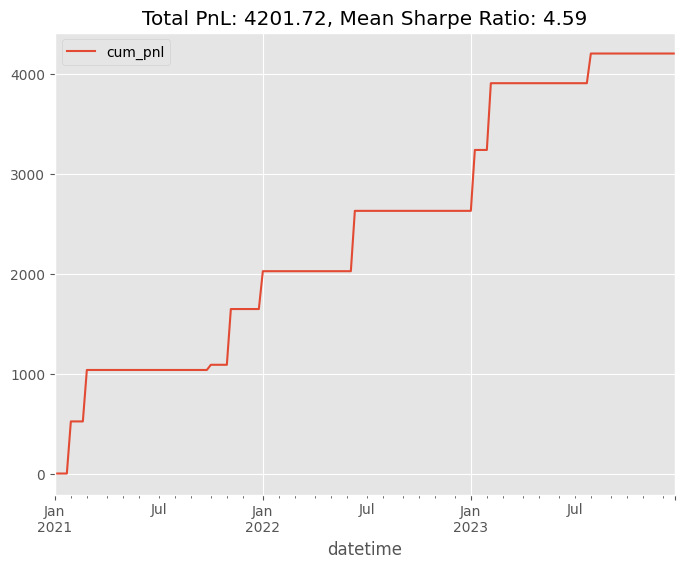

In [9]:
backtest = Backtest(df=df)
df_result, df_trade = backtest.fit(MeanReversionStrategy, z_score_threshold=3.0)
res_hold = backtest.evaluate()

In [10]:
class MeanReversionStrategy(Strategy):
    params = (
        ('z_score_threshold', 3),  # Z-score threshold for entry
        ('entry_time_start', bt.datetime.time(10, 25)),  # Entry time window start
        ('entry_time_end', bt.datetime.time(10, 35)),  # Entry time window end
        ('exit_time', bt.datetime.time(12, 0)),  # Exit time
        ('buffer', None),
        ('total_len', 120),
        ('period', 30),
        # ('margin', 0.07),
    )

    def __init__(self):
        super().__init__()
        self.dataclose = self.datas[0].close
        self.std = bt.indicators.StandardDeviation(self.dataclose, period=self.params.period)
        self.sma = bt.indicators.SimpleMovingAverage(self.dataclose, period=self.params.period)
        self.z_score = (self.dataclose - self.sma) / self.std
        self.order = None

    def next(self):
        dt = self.data.datetime.time()

        cash = self.broker.get_cash()
        size = cash // self.dataclose[0]

        # Check if it's within the entry time window
        if self.params.entry_time_start <= dt < self.params.entry_time_end:
            # Check if the z-score exceeds the threshold
            if self.z_score[0] > self.params.z_score_threshold:
                # Enter a short position
                # size = int(self.broker.getvalue() * self.params.margin / self.dataclose[0])
                # if size >= 1:
                self.log(f'Short at {self.dataclose[0]:.2f}')
                self.sell()
            elif self.z_score[0] < -self.params.z_score_threshold:
                # Enter a long position
                # if size >= 1:
                self.log(f'Long at {self.dataclose[0]:.2f}')
                self.buy()

        # Check if we have an open position
        if self.position.size > 0:
            # Check if the z-score has reverted to 0 or if it's time to exit
            if (self.z_score[0] > 0) or dt >= self.params.exit_time:
                self.close_position = True
                self.close()  # Close the position
        
        elif self.position.size < 0:
            if (self.z_score[0] < 0) or dt >= self.params.exit_time:
                self.close_position = True
                self.log(f'Close at {self.dataclose[0]:.2f}')
                self.close()

Starting Portfolio Value: 100000.00
2021-01-06T10:30:00, Short at 50.20, Cash: 100000.00, Portfolio Value: 100000.00, Shares Owned: 0
2021-01-06T10:31:00, Sell executed at 50.21, Cash: 200019.92, Portfolio Value: 100079.68, Shares Owned: -1992
2021-01-06T10:32:00, Short at 50.31, Cash: 200019.92, Portfolio Value: 99800.80, Shares Owned: -1992
2021-01-06T10:33:00, Sell executed at 50.32, Cash: 300258.96, Portfolio Value: 99860.56, Shares Owned: -3984
2021-01-06T10:53:00, Close at 50.22, Cash: 300258.96, Portfolio Value: 100179.28, Shares Owned: -3984
2021-01-06T10:54:00, Buy executed at 50.22, Cash: 100179.28, Portfolio Value: 100179.28, Shares Owned: 0
2021-01-06T10:54:00, OPERATION PROFIT, GROSS 179.28, NET 179.28, Cash: 100179.28, Portfolio Value: 100179.28, Shares Owned: 0
Final Portfolio Value: 100179.28



Starting Portfolio Value: 100179.28
Final Portfolio Value: 100179.28



Starting Portfolio Value: 100179.28
Final Portfolio Value: 100179.28



Starting Portfolio Value: 100179.

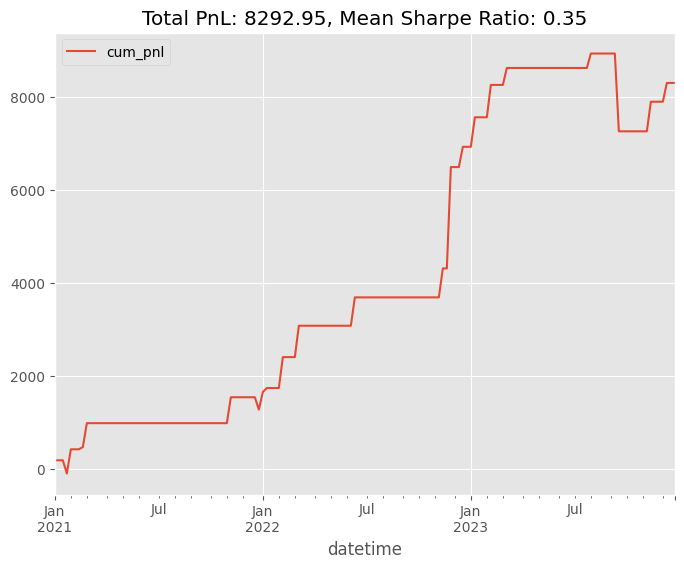

In [11]:
backtest = Backtest(df=df)
df_result, df_trade = backtest.fit(MeanReversionStrategy, z_score_threshold=3.0)
res_hold = backtest.evaluate()